In [1]:
# This code is used to compute the MSE
# between predicted shape and actual shape
# Steps involves:
# 1. Fold the original image horizontally at the center
# (Mirror the top part on to the bottom and add,
# then give pixel value 1 to all values other than 0)
# 2. Fold the predicted image similarly 
# (Mirror the top part on to the bottom and add,
# then normalize the image)

In [2]:
# Import necessary libraries

# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model
import sys


2023-09-30 14:39:59.771582: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-30 14:40:00.676302: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


In [3]:
# test_shape_dir  = '../data/data_npy/shape_npy/shape_filled8.npy'
# test_shape = np.load(test_shape_dir)
# # Normalize the image, convert to opacity map
# ## Test Set
# test_shape = test_shape/np.amax(test_shape)
# test_shape_where_0 = np.where(test_shape == 0)
# test_shape_where_1 = np.where(test_shape == 1)
# test_shape[test_shape_where_0] = 1  # 1 represent the shape (1 opacity)
# test_shape[test_shape_where_1] = 0  # 0 represent background (0 opacity)

test Set: No. of LC = No. of shapes
Extended the light curves


2023-09-30 14:40:03.133905: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30931 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-09-30 14:40:05.492403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


2/2 [==============================] - 3s 160ms/step - loss: 0.1113
SNR = 500. Loss -> 0.11126464605331421
8/8 [==============================] - 0s 20ms/step
Normalized the predicted shape
2/2 [==============================] - 0s 10ms/step - loss: 0.1196
SNR = 200. Loss -> 0.11955643445253372
8/8 [==============================] - 0s 5ms/step
Normalized the predicted shape
2/2 [==============================] - 0s 8ms/step - loss: 0.1247
SNR = 150. Loss -> 0.12473542988300323
8/8 [==============================] - 0s 5ms/step
Normalized the predicted shape
2/2 [==============================] - 0s 8ms/step - loss: 0.1324
SNR = 100. Loss -> 0.13240297138690948
8/8 [==============================] - 0s 4ms/step
Normalized the predicted shape
2/2 [==============================] - 0s 11ms/step - loss: 0.1380
SNR = 75. Loss -> 0.13795024156570435
8/8 [==============================] - 0s 5ms/step
Normalized the predicted shape
2/2 [==============================] - 0s 8ms/step - loss: 0.

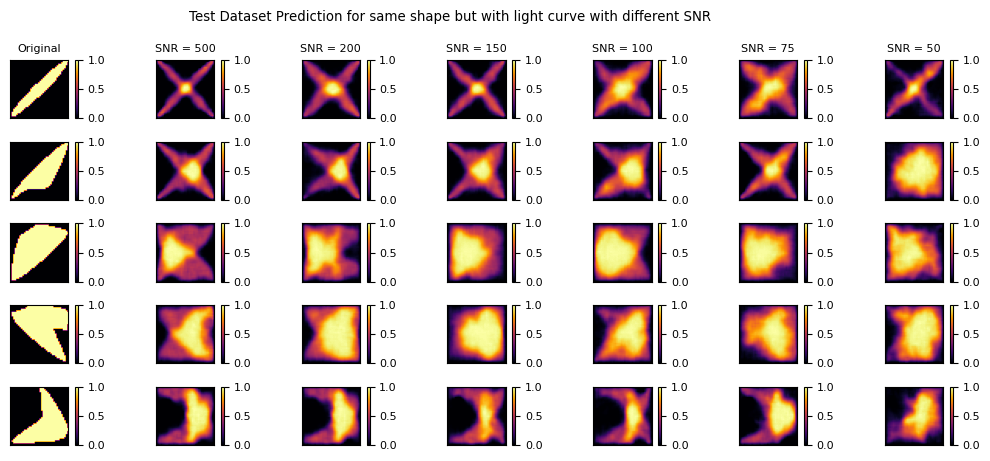

In [4]:
# Load Test Dataset
# test_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled8.npy'
# test_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_8.npy'
test_lc_dir = '../data/data_npy/lc_npy/lc_dict_8.npy'
test_shape_dir  = '../data/data_npy/shape_npy/shape_filled8.npy'


test_lc = np.load(test_lc_dir)
test_shape = np.load(test_shape_dir)
# Check equality of number of dataset
if len(test_lc)==len(test_shape):
    print("test Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: testn Set: No. of LC != No. of shapes")

# Normalize the image, convert to opacity map
## Test Set
test_shape = test_shape/np.amax(test_shape)
test_shape_where_0 = np.where(test_shape == 0)
test_shape_where_1 = np.where(test_shape == 1)
test_shape[test_shape_where_0] = 1  # 1 represent the shape (1 opacity)
test_shape[test_shape_where_1] = 0  # 0 represent background (0 opacity)


# Normalize the lightcurves
## - Test Set
test_lc_scaled = np.zeros(test_lc.shape)
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled[i] = (test_lc[i] - np.amin(test_lc[i]))/(np.amax(test_lc[i]) - np.amin(test_lc[i]))

# Append with ones
## - Test Set
test_lc_scaled_append = np.ones((test_lc.shape[0],120))
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled_append[i,10:110] = test_lc_scaled[i]
print("Extended the light curves")

# Function to Add noise to Test light curve
def add_noise(test_lc_scaled_append,SNR):
    std_dev = 1/SNR
    test_lc_scaled_append_noise = np.ones(test_lc_scaled_append.shape)
    rng = np.random.default_rng()

    for i in np.arange(len(test_lc_scaled_append)):
        noise_temp = np.random.normal(loc=0.0, scale=std_dev, size=len(test_lc_scaled_append[i]))
        rng.shuffle(noise_temp)
        test_lc_scaled_append_noise[i] = test_lc_scaled_append[i] + noise_temp
    return test_lc_scaled_append_noise

# Add noise to the light curve
test_lc_SNR500 =add_noise(test_lc_scaled_append,SNR=500)
test_lc_SNR200 =add_noise(test_lc_scaled_append,SNR=200)
test_lc_SNR150 =add_noise(test_lc_scaled_append,SNR=150)
test_lc_SNR100 =add_noise(test_lc_scaled_append,SNR=100)
test_lc_SNR75 =add_noise(test_lc_scaled_append,SNR=75)
test_lc_SNR50 =add_noise(test_lc_scaled_append,SNR=50)
test_lc_SNR35 =add_noise(test_lc_scaled_append,SNR=35)
test_lc_SNR20 =add_noise(test_lc_scaled_append,SNR=20)

# Experiment 2
# Switch on one MODEL and test on LC with different SNR
# Function to normalize predicted shape
def normalize_shape(test_predict_shape):
    test_predict_shape_normalized = np.zeros(test_predict_shape.shape)
    for i in np.arange(len(test_predict_shape)):
        test_predict_shape_normalized[i] = (test_predict_shape[i] - np.amin(test_predict_shape[i]))/(np.amax(test_predict_shape[i]) - np.amin(test_predict_shape[i]))
    print("Normalized the predicted shape")
    return test_predict_shape_normalized

#Load ML model
tf.keras.backend.clear_session()
model_SNR = load_model("../ml_model/sep22_singleModel_uniform_SNR/model_sep22_unf_50_500_v1.h5")

results = model_SNR.evaluate(test_lc_SNR500, test_shape, batch_size=128)
print("SNR = 500. Loss ->",results)
test_predict_shape_SNR500 = model_SNR.predict(test_lc_SNR500)
test_predict_shape_SNR500 = normalize_shape(test_predict_shape_SNR500)

results = model_SNR.evaluate(test_lc_SNR200, test_shape, batch_size=128)
print("SNR = 200. Loss ->",results)
test_predict_shape_SNR200 = model_SNR.predict(test_lc_SNR200)
test_predict_shape_SNR200 = normalize_shape(test_predict_shape_SNR200)

results = model_SNR.evaluate(test_lc_SNR150, test_shape, batch_size=128)
print("SNR = 150. Loss ->",results)
test_predict_shape_SNR150 = model_SNR.predict(test_lc_SNR150)
test_predict_shape_SNR150 = normalize_shape(test_predict_shape_SNR150)

results = model_SNR.evaluate(test_lc_SNR100, test_shape, batch_size=128)
print("SNR = 100. Loss ->",results)
test_predict_shape_SNR100 = model_SNR.predict(test_lc_SNR100)
test_predict_shape_SNR100 = normalize_shape(test_predict_shape_SNR100)

results = model_SNR.evaluate(test_lc_SNR75, test_shape, batch_size=128)
print("SNR = 75. Loss ->",results)
test_predict_shape_SNR75 = model_SNR.predict(test_lc_SNR75)
test_predict_shape_SNR75 = normalize_shape(test_predict_shape_SNR75)

results = model_SNR.evaluate(test_lc_SNR50, test_shape, batch_size=128)
print("SNR = 50. Loss ->",results)
test_predict_shape_SNR50 = model_SNR.predict(test_lc_SNR50)
test_predict_shape_SNR50 = normalize_shape(test_predict_shape_SNR50)

# Plot predicted shapes
num = 5
fig,ax=plt.subplots(num,7, figsize=(13,5), gridspec_kw={ 'width_ratios': [1,1,1,1,1,1,1],
        'wspace': 0.1,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 1000
plt.rcParams.update({'font.size': 8})

ax[0][0].set_title('Original',size=8)
ax[0][1].set_title('SNR = 500',size=8)
ax[0][2].set_title('SNR = 200',size=8)
ax[0][3].set_title('SNR = 150',size=8)
ax[0][4].set_title('SNR = 100',size=8)
ax[0][5].set_title('SNR = 75',size=8)
ax[0][6].set_title('SNR = 50',size=8)



temp = np.linspace(0, len(test_lc_scaled_append)-1,len(test_lc_scaled_append))
index_test_array = np.random.choice(temp, size=(num,), replace=False)

for i in range(num):
    k =  i # int(index_test_array[i]) # random.randint(0, len(test_lc_scaled_append)-1) # i
    print("k = ",k)
    ax[i][0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][3].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][4].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][5].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][6].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)

    img = ax[i][0].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)  

    img = ax[i][1].imshow(test_predict_shape_SNR500[k],cmap='inferno')
    plt.colorbar(img)   

    img = ax[i][2].imshow(test_predict_shape_SNR200[k],cmap='inferno')
    plt.colorbar(img)   

    img = ax[i][3].imshow(test_predict_shape_SNR150[k],cmap='inferno')
    plt.colorbar(img)     

    img = ax[i][4].imshow(test_predict_shape_SNR100[k],cmap='inferno')
    plt.colorbar(img)  

    img = ax[i][5].imshow(test_predict_shape_SNR75[k],cmap='inferno')
    plt.colorbar(img)     

    img = ax[i][6].imshow(test_predict_shape_SNR50[k],cmap='inferno')
    plt.colorbar(img)

plt.suptitle('Test Dataset Prediction for same shape but with light curve with different SNR')
plt.show()

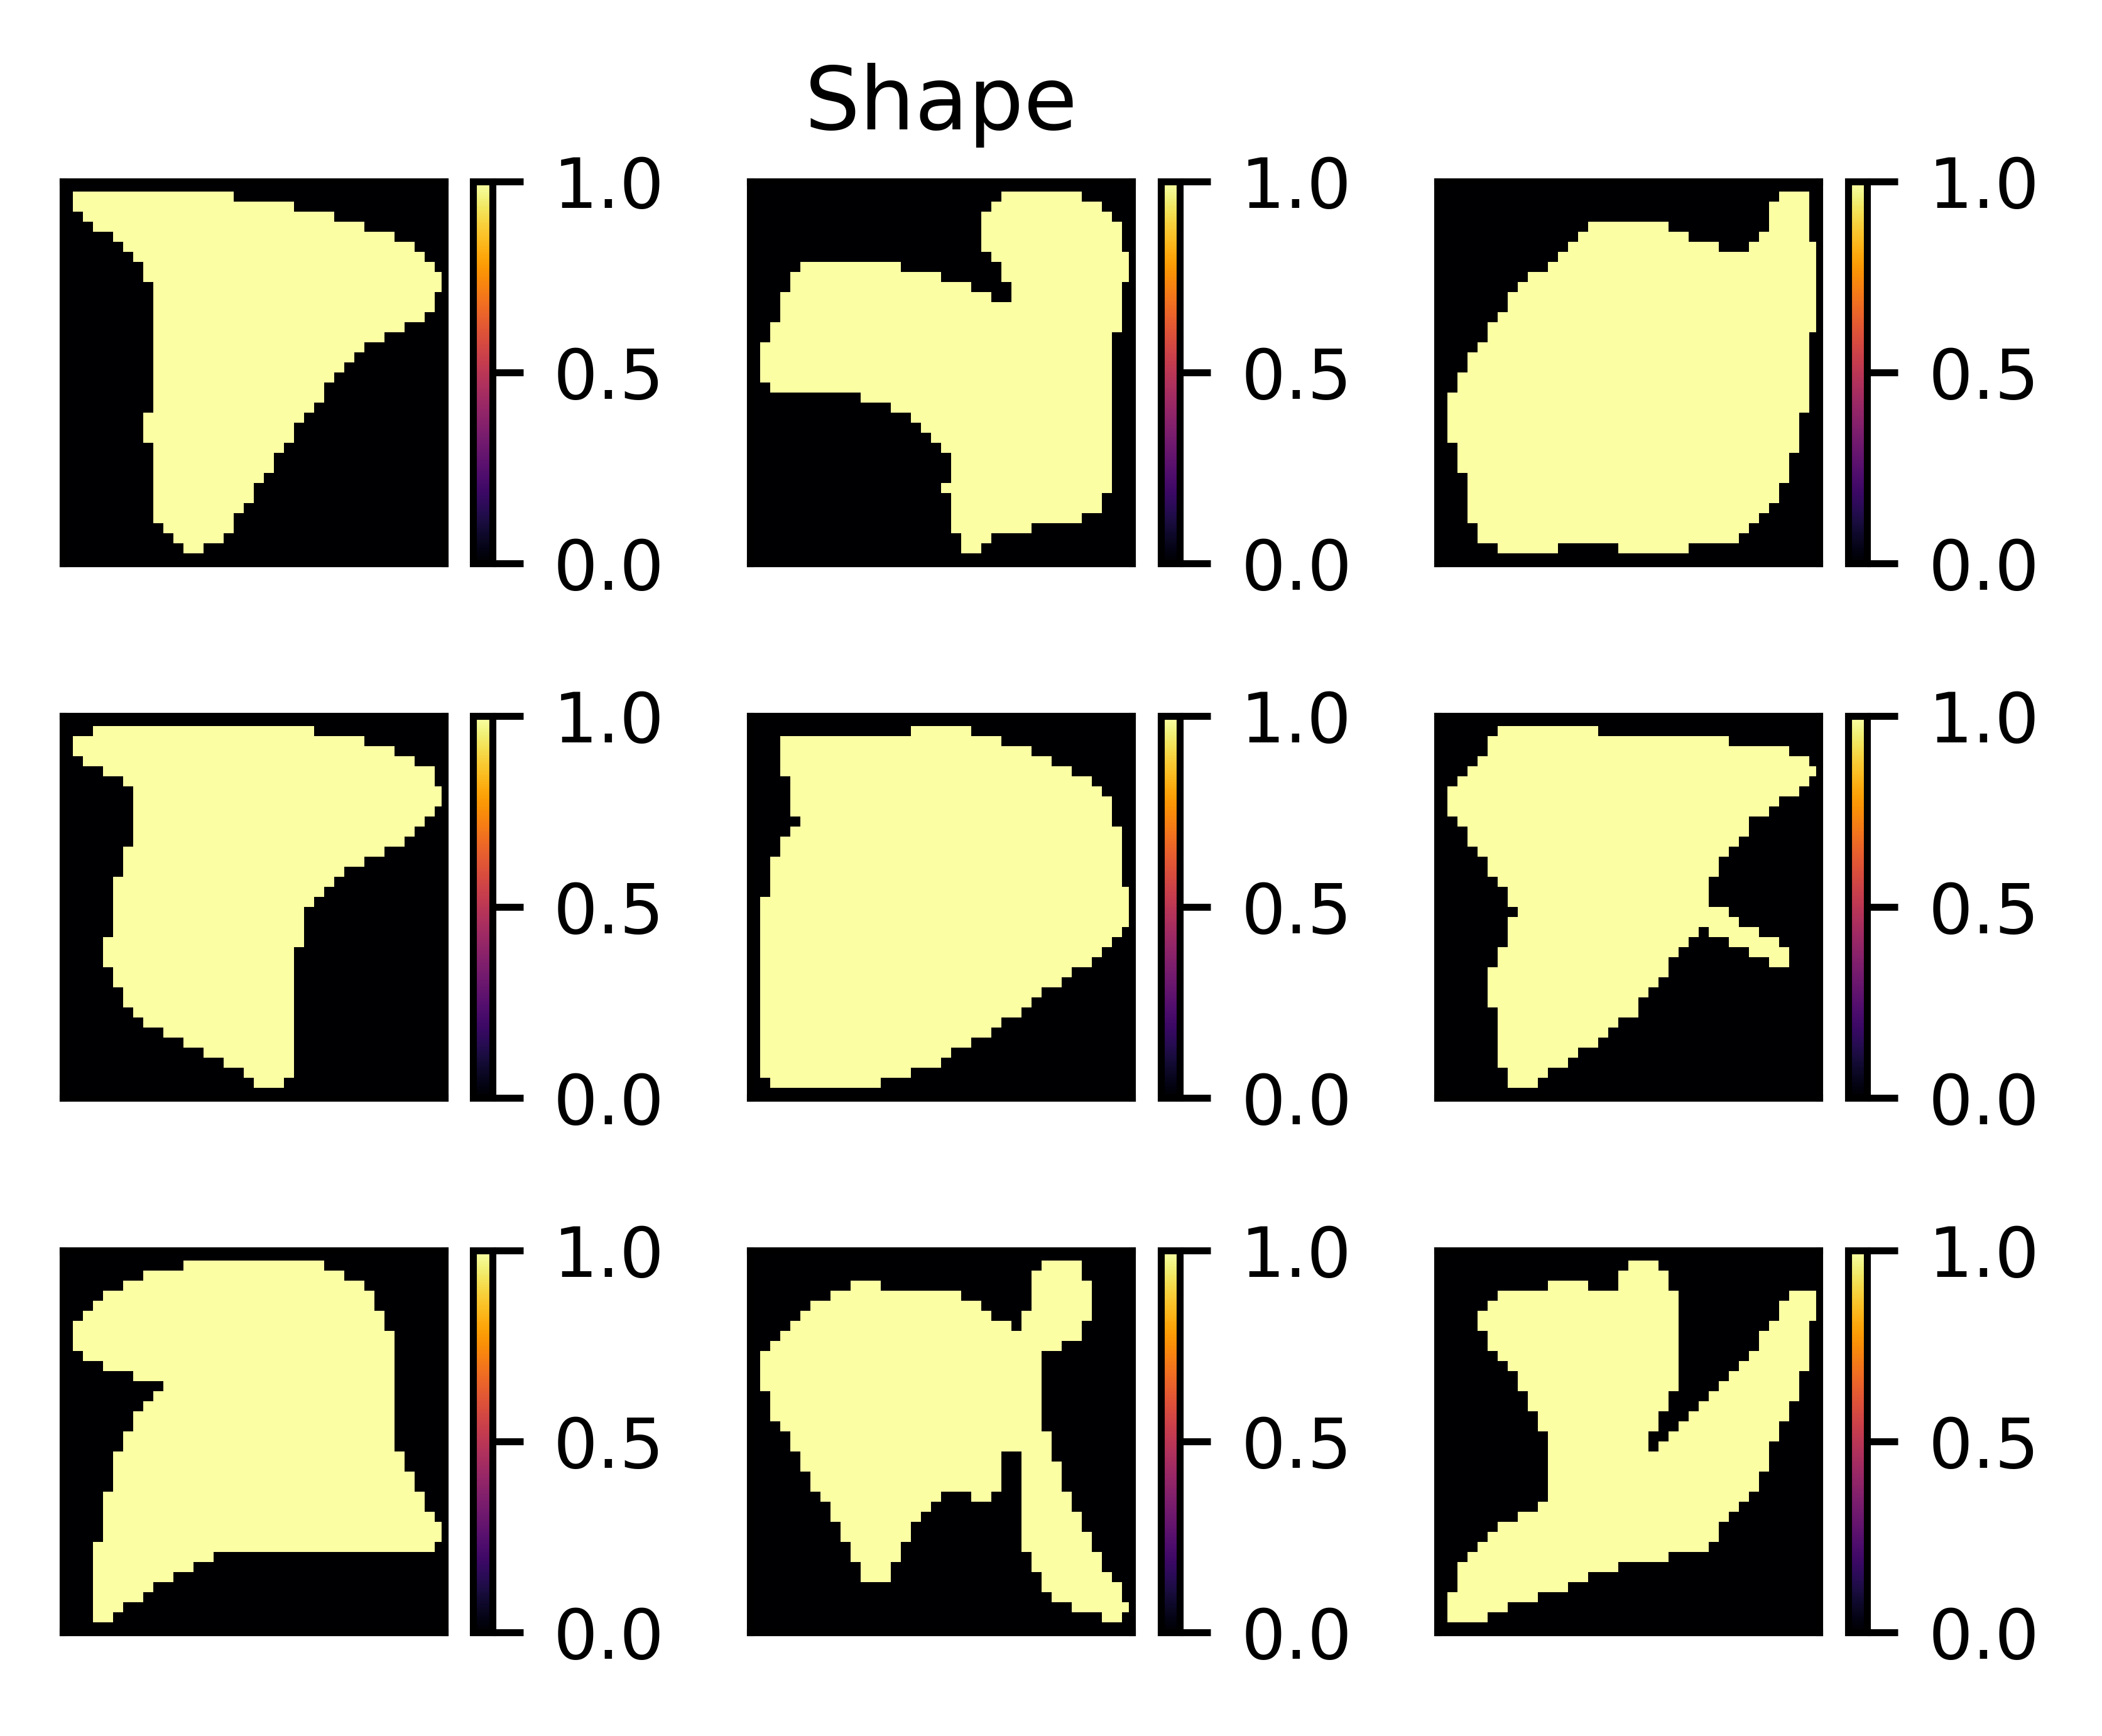

In [5]:
# Verification
# Plot - Test LCs
num = 3
fig,ax=plt.subplots(num,3, figsize=(4,3), gridspec_kw={ 'width_ratios': [1,1,1],
        'wspace': 0.2,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 400

ax[0][1].set_title('Shape',size=10)

# advance = 60

i = 0
for i in np.arange(0,num):
    k = np.random.randint(0, len(test_shape)-1)
    ax[i][0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    img = ax[i][0].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)
    
    k = np.random.randint(0, len(test_shape)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    img = ax[i][1].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)
    
    k = np.random.randint(0, len(test_shape)-1)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    img = ax[i][2].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)

    i = i + 1

fold_test_shape.shape =  (19, 38)


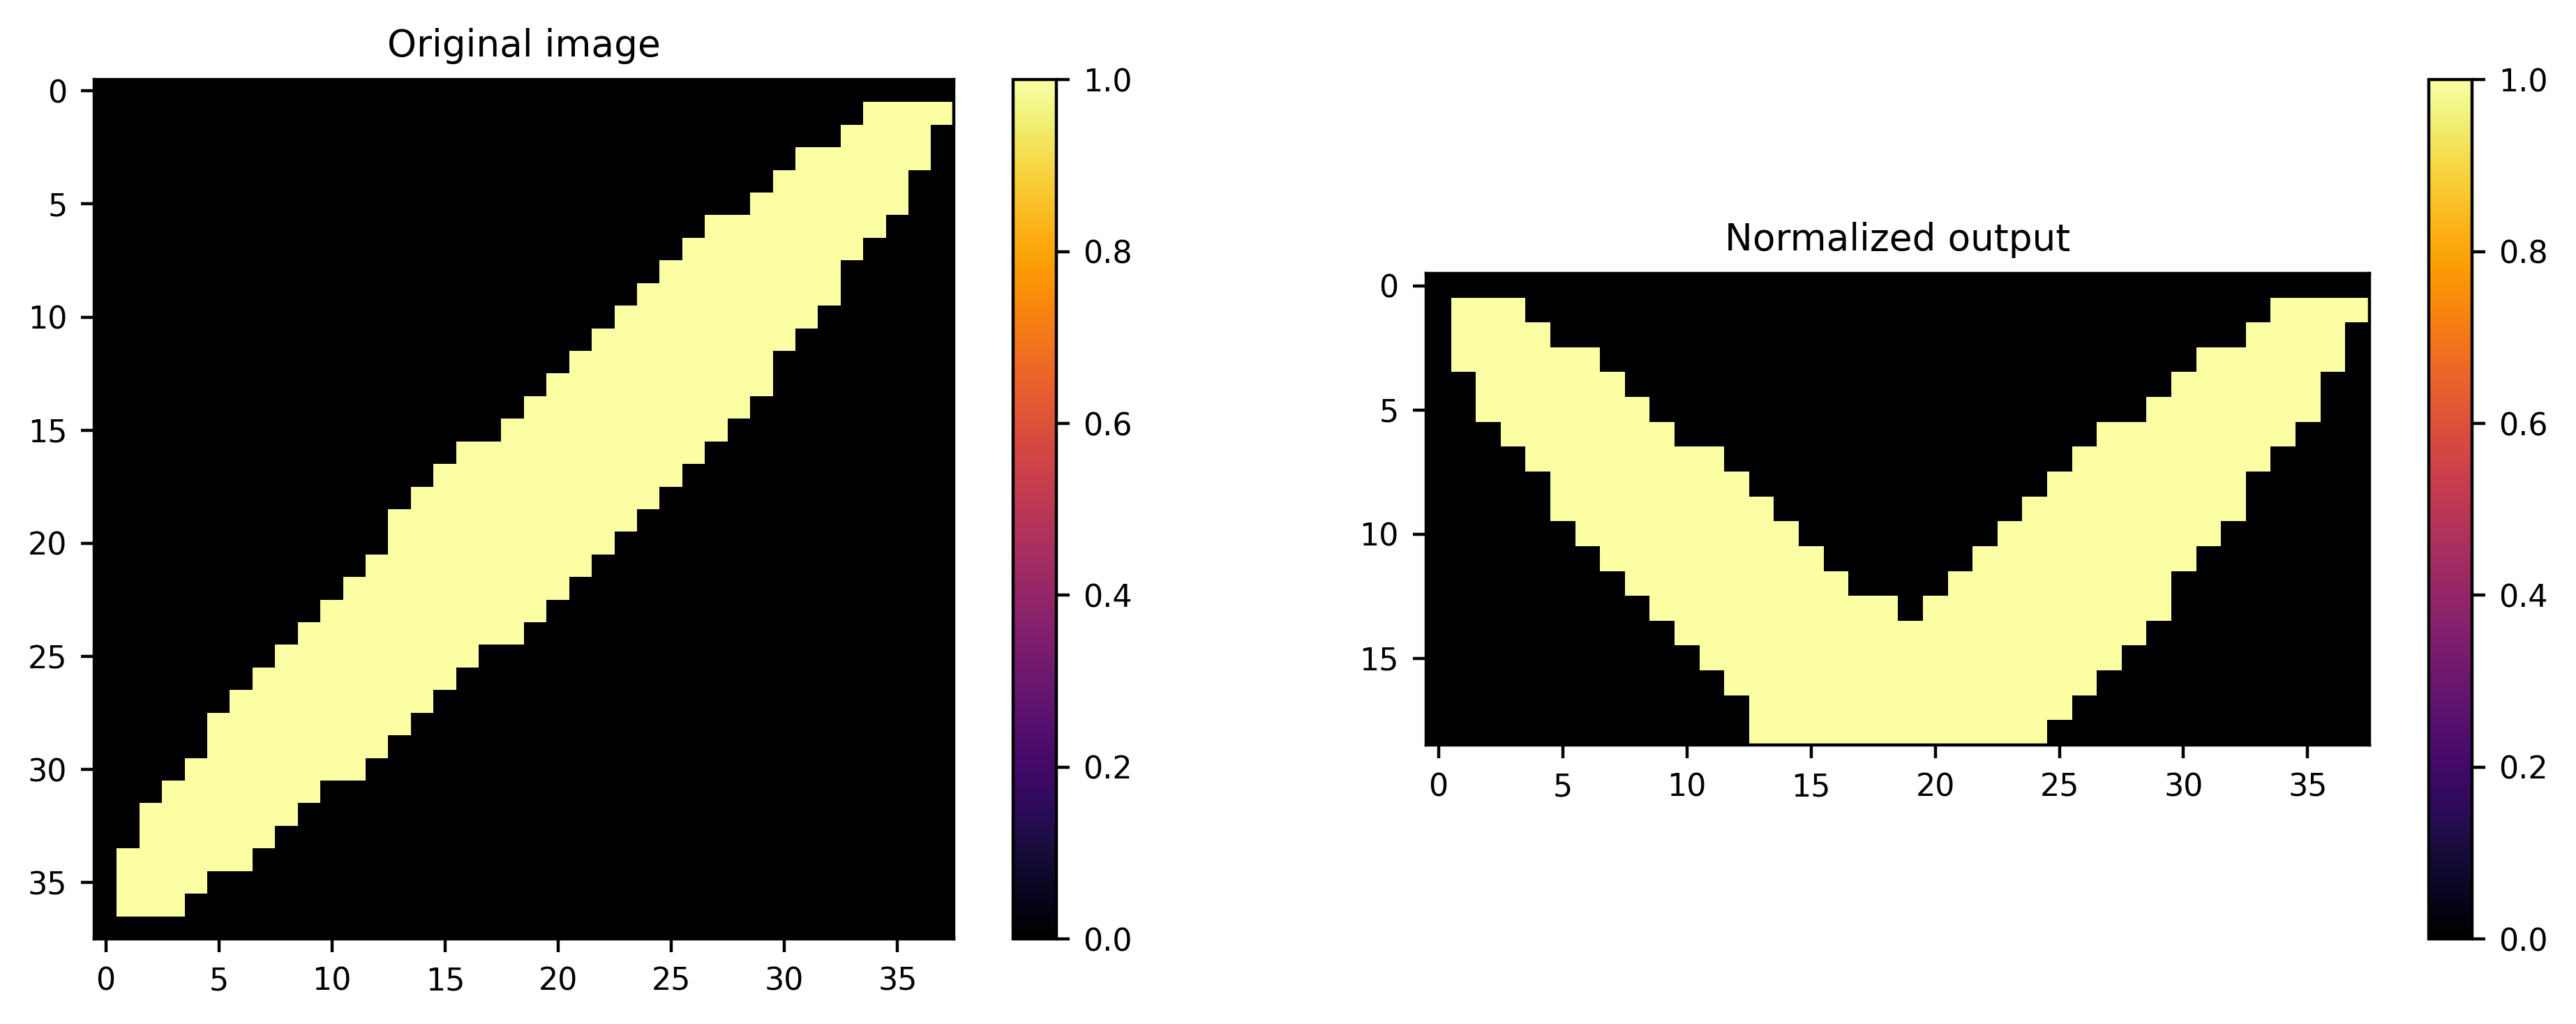

In [8]:
def fold_original_image(org_image):
    """
    Fold an input image in half along its vertical axis.

    This function takes an input image, 'org_image,' and folds it vertically along its
    central axis. The folding process involves splitting the input image into two halves,
    flipping the bottom half vertically, and then merging the flipped bottom half with
    the top half to create a folded image.

    Parameters:
    ----------
    org_image : numpy.ndarray
        The input image to be folded. It should be a 2D NumPy array representing
        grayscale pixel values, where higher values typically represent brighter areas.

    Returns:
    -------
    folded_image : numpy.ndarray
        The folded image resulting from the vertical folding of 'org_image.' It is a
        2D NumPy array of the same shape as the input image, with the bottom half flipped
        and merged with the top half. The pixel values may be thresholded to 1 (white) or 0 (black)
        based on whether they are greater than 0.

    Example:
    --------
    import numpy as np
    org_image = np.random.random((100, 200))  # Replace with your input image
    folded_result = fold_original_image(org_image)
    plt.imshow(folded_result, cmap='gray')
    plt.title('Folded Image')
    plt.show()
    """
    # image = np.zeros((int(org_image.shape[0]/2),int(org_image.shape[1])))
    image_top = org_image[0:int(org_image.shape[0]/2),:]
    image_bottom = org_image[int(org_image.shape[0]/2):,:]
    image_bottom_flip = np.flipud(image_bottom)
    folded_image = image_bottom_flip+image_top
    # folded_image_normalized = (folded_image - np.amin(folded_image))/(np.amax(folded_image) - np.amin(folded_image))
    folded_image[folded_image>0] = 1
    return(folded_image)

# Code to test the above function
fold_test_shape = fold_original_image(test_shape[0])
print("fold_test_shape.shape = ",fold_test_shape.shape)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

im = ax[0].imshow(test_shape[0], cmap='inferno')
ax[0].set_title('Original image')
plt.colorbar(im)

im = ax[1].imshow(fold_test_shape, cmap='inferno')
ax[1].set_title('Normalized output')
plt.colorbar(im)

plt.show()

folded_predicted_image.shape =  (19, 38)


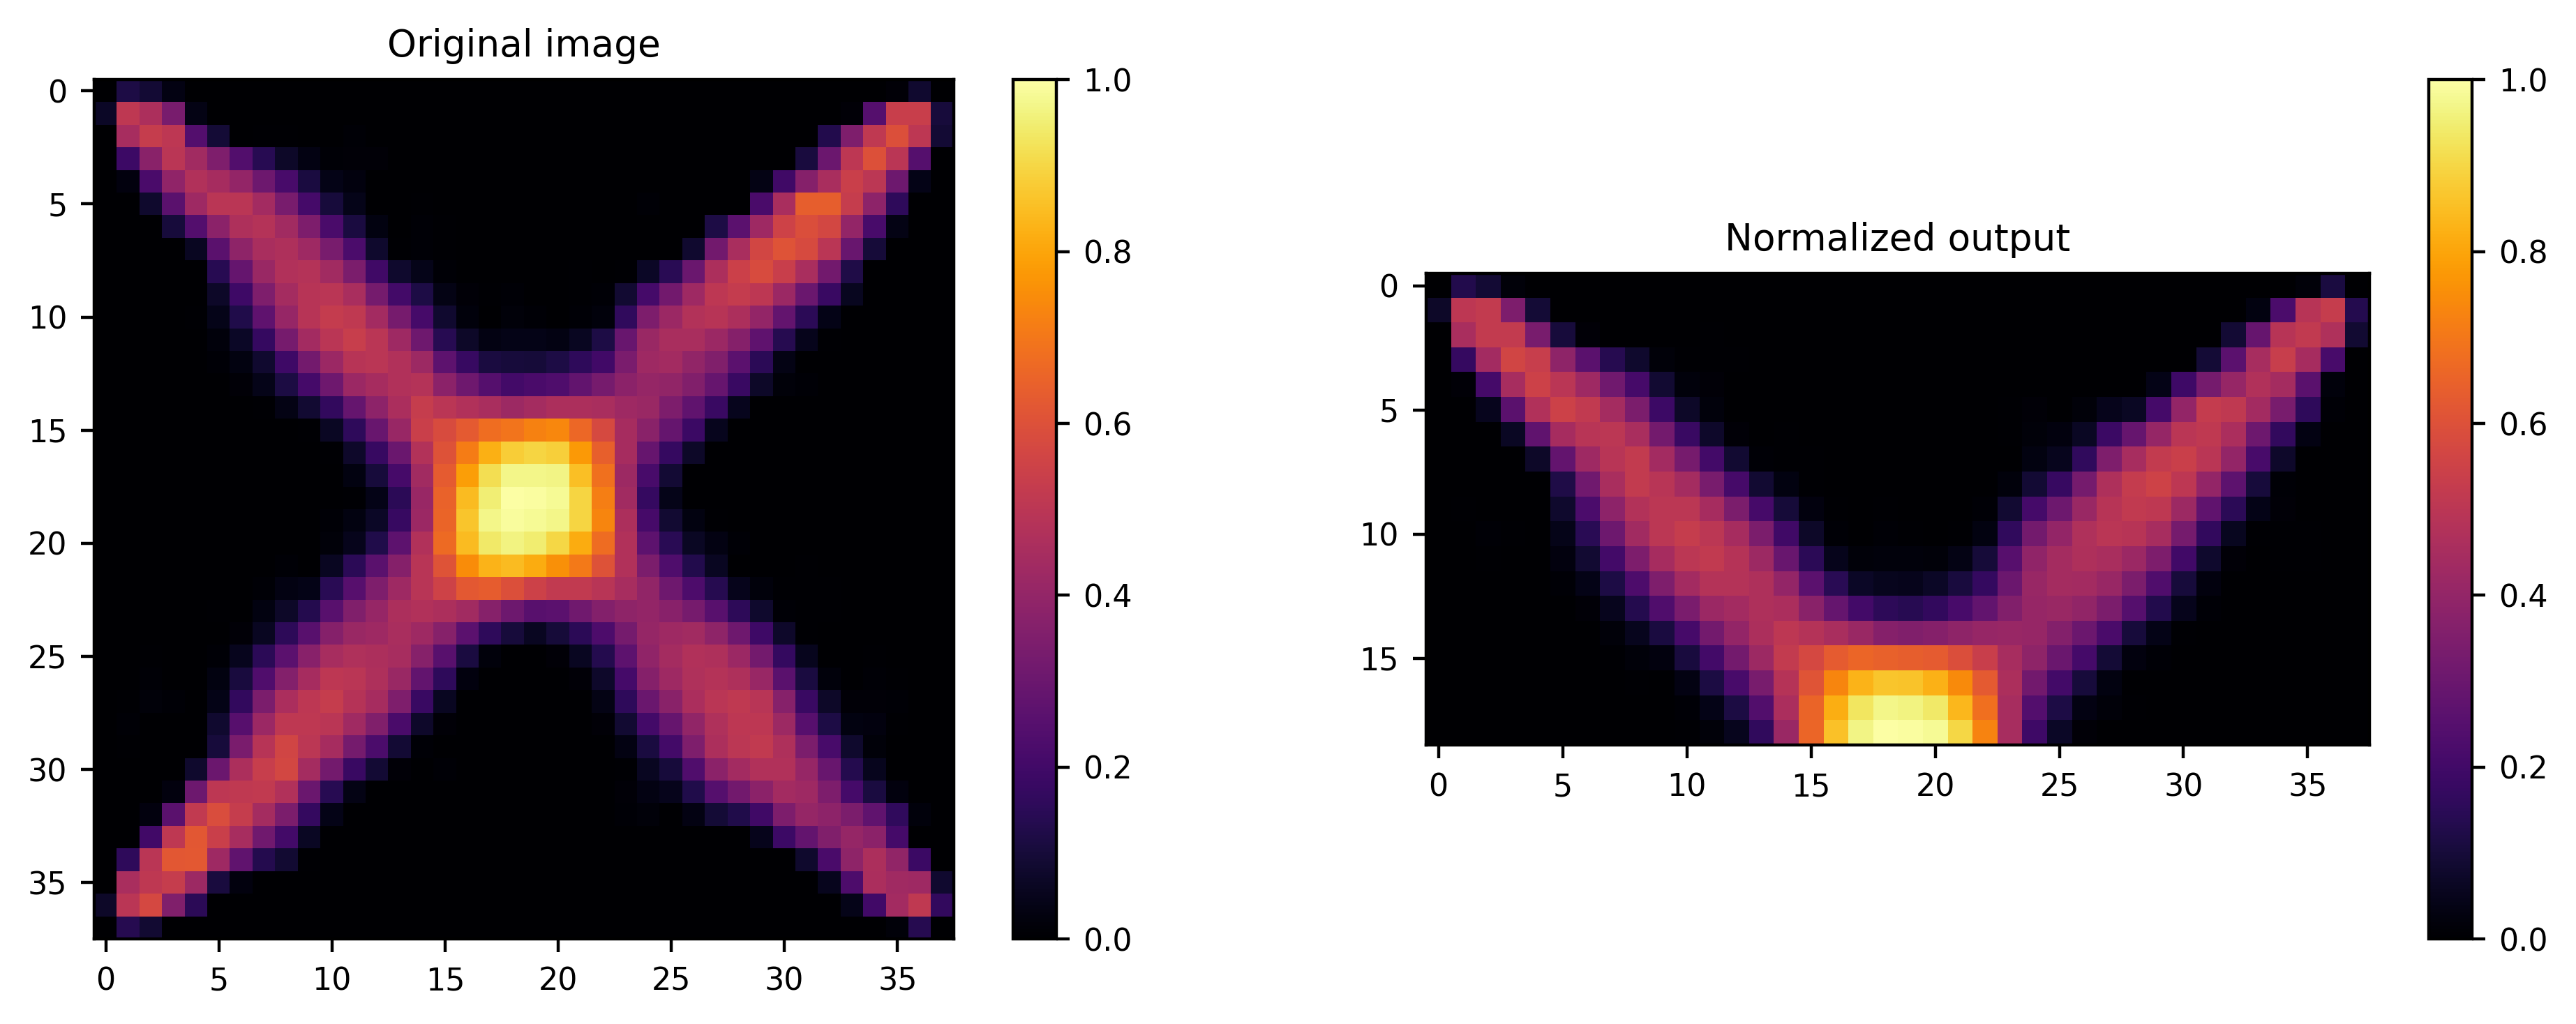

In [10]:
def fold_predicted_image(predicted_image):
    image_top = predicted_image[0:int(predicted_image.shape[0]/2),:]
    image_bottom = predicted_image[int(predicted_image.shape[0]/2):,:]
    image_bottom_flip = np.flipud(image_bottom)
    folded_predicted_image = image_bottom_flip+image_top
    folded_image_normalized = (folded_predicted_image - np.amin(folded_predicted_image))/(np.amax(folded_predicted_image) - np.amin(folded_predicted_image))
    # folded_image[folded_image>0] = 1
    return(folded_image_normalized)


# Code to test the above function
folded_predicted_image = fold_predicted_image(test_predict_shape_SNR500[0])
print("folded_predicted_image.shape = ",folded_predicted_image.shape)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

im = ax[0].imshow(test_predict_shape_SNR500[0], cmap='inferno')
ax[0].set_title('Original image')
plt.colorbar(im)

im = ax[1].imshow(folded_predicted_image, cmap='inferno')
ax[1].set_title('Normalized output')
plt.colorbar(im)

plt.show()